In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df= pd.read_csv('/content/ai_job_market_insights.csv')

In [ ]:
df
data=df

In [ ]:
df.head()

,Job_Title,Industry,Company_Size,Location,AI_Adoption_Level,Automation_Risk,Required_Skills,Salary_USD,Remote_Friendly,Job_Growth_Projection
0,Cybersecurity Analyst,Entertainment,Small,Dubai,Medium,High,UX/UI Design,111392.165243,Yes,Growth
1,Marketing Specialist,Technology,Large,Singapore,Medium,High,Marketing,93792.562466,No,Decline
2,AI Researcher,Technology,Large,Singapore,Medium,High,UX/UI Design,107170.263069,Yes,Growth
3,Sales Manager,Retail,Small,Berlin,Low,High,Project Management,93027.953758,No,Growth
4,Cybersecurity Analyst,Entertainment,Small,Tokyo,Low,Low,JavaScript,87752.922171,Yes,Decline


In [ ]:
df['Salary_USD'] = df['Salary_USD'].astype(int)

In [ ]:
df['Job_Title'] = df['Job_Title'].astype('category').cat.codes
df['Industry'] = df['Industry'].astype('category').cat.codes
df['Location'] = df['Location'].astype('category').cat.codes
df['Company_Size'] = df['Company_Size'].astype('category').cat.codes
df['Required_Skills'] = df['Required_Skills'].astype('category').cat.codes
df['Automation_Risk'] = df['Automation_Risk'].astype('category').cat.codes
df['Job_Growth_Projection'] = df['Job_Growth_Projection'].astype('category').cat.codes
df['AI_Adoption_Level'] = df['AI_Adoption_Level'].astype('category').cat.codes

In [ ]:
df = df.drop('Remote_Friendly', axis=1)

In [ ]:
df.head()

,Job_Title,Industry,Company_Size,Location,AI_Adoption_Level,Automation_Risk,Required_Skills,Salary_USD,Job_Growth_Projection
0,1,2,2,1,2,0,9,111392,1
1,4,7,0,6,2,0,5,93792,0
2,0,7,0,6,2,0,9,107170,1
3,7,6,2,0,1,0,6,93027,1
4,1,2,2,8,1,1,3,87752,0


In [ ]:
df.to_csv('/content/ai_job_market_insights2.csv', index=False)

In [ ]:
import numpy as np

# Standardizing the data (mean = 0, variance = 1)
data=df
data_standardized = (data - data.mean()) / data.std()

def pca_from_scratch(data, n_components):
    # Step 1: Calculate the covariance matrix
    covariance_matrix = np.cov(data.T)

    # Step 2: Perform eigen decomposition
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

    # Step 3: Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigen_values)[::-1]
    sorted_eigenvalues = eigen_values[sorted_indices]
    sorted_eigenvectors = eigen_vectors[:, sorted_indices]

    # Step 4: Select the top n_components
    selected_eigenvectors = sorted_eigenvectors[:, :n_components]

    # Step 5: Transform the data
    reduced_data = np.dot(data, selected_eigenvectors)

    return reduced_data, sorted_eigenvalues, sorted_eigenvectors

# Perform PCA to reduce the dataset to 2 dimensions
reduced_data, eigenvalues, eigenvectors = pca_from_scratch(data_standardized.values, n_components=2)
print(reduced_data[:5])  # Display the first 5 rows of reduced data

[[ 2.19253543  0.47308783]
 [ 0.89905629  1.0310584 ]
 [ 1.37140972  2.49184825]
 [ 0.21787428 -0.46373951]
 [ 0.93919481 -1.47642994]]


In [ ]:
import numpy as np

# Initialize k centroids randomly from the dataset
def initialize_centroids(data, k):
    indices = np.random.choice(data.shape[0], size=k, replace=False)
    return data[indices, :]

# Assign each point to the nearest centroid
def assign_clusters(data, centroids):
    distances = np.sqrt(((data - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    return np.argmin(distances, axis=0)

# Update centroids to the mean of their assigned points
def update_centroids(data, labels, k):
    return np.array([data[labels == i].mean(axis=0) for i in range(k)])

# K-Means algorithm with EM step
def kmeans_em(data, k, max_iters=100, tol=1e-4):
    # Step 1: Initialize centroids
    centroids = initialize_centroids(data, k)

    for i in range(max_iters):
        # Step 2: E-step: Assign clusters
        labels = assign_clusters(data, centroids)

        # Step 3: M-step: Update centroids
        new_centroids = update_centroids(data, labels, k)

        # Step 4: Check for convergence
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids

    return labels, centroids

# Apply K-Means with EM to the reduced data (from PCA)
k = 2  # Choose the number of clusters
labels, centroids = kmeans_em(reduced_data, k)

print(labels[:5])  # Print first 5 cluster labels
print(centroids)   # Print final centroids

[1 1 1 1 1]
[[-0.93118893 -0.0518906 ]
 [ 0.86647309  0.0482843 ]]


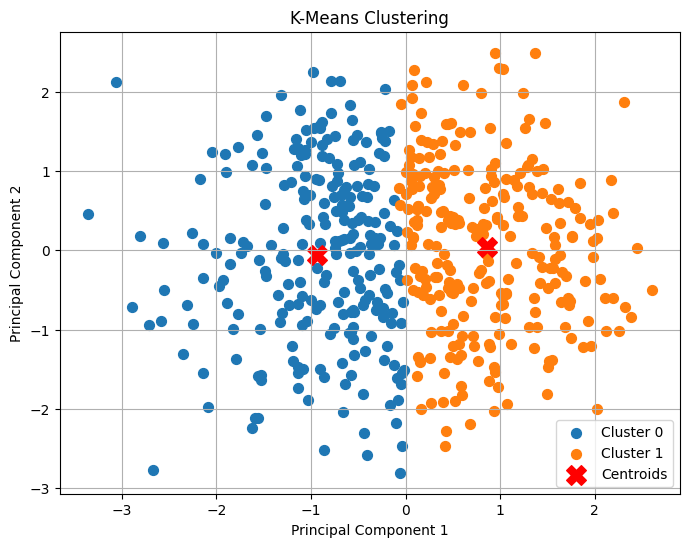

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize the clustering results
def plot_clusters(data, labels, centroids, title='K-Means Clustering'):
    # Create a scatter plot
    plt.figure(figsize=(8, 6))

    # Plot each cluster with a different color
    for cluster in np.unique(labels):
        plt.scatter(data[labels == cluster, 0], data[labels == cluster, 1],
                    label=f'Cluster {cluster}', s=50)

    # Plot the centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], s=200, color='red', marker='X', label='Centroids')

    # Labeling
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize the clustering results
plot_clusters(reduced_data, labels, centroids)

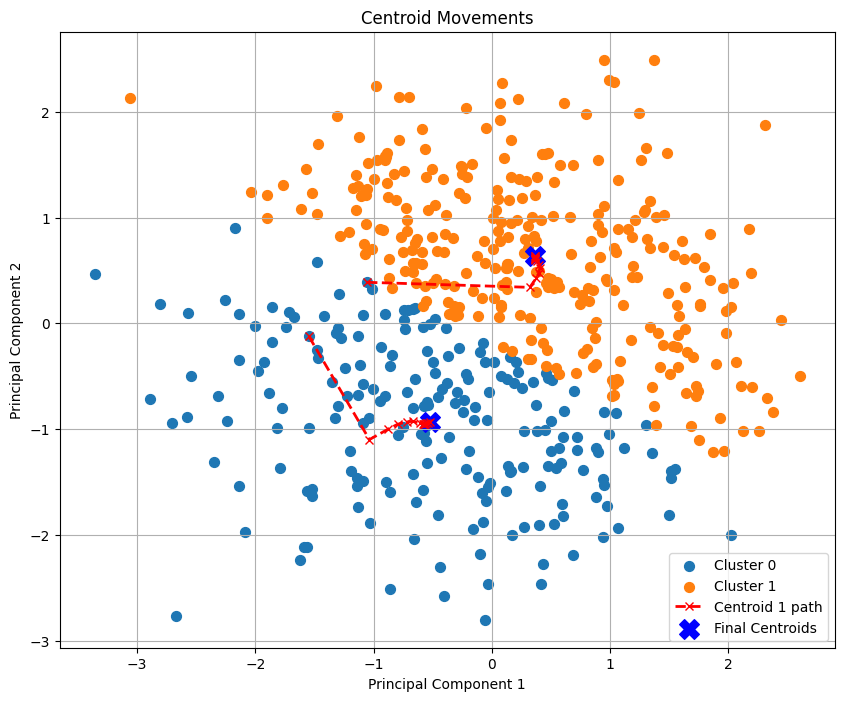

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Modified k-means to track centroid movements
def kmeans_em_with_tracking(data, k, max_iters=100, tol=1e-4):
    """K-Means algorithm with EM step, tracking centroids over iterations."""
    # Step 1: Initialize centroids
    centroids = initialize_centroids(data, k)
    centroids_history = [centroids.copy()]

    for i in range(max_iters):
        # Step 2: E-step: Assign clusters
        labels = assign_clusters(data, centroids)

        # Step 3: M-step: Update centroids
        new_centroids = update_centroids(data, labels, k)

        # Step 4: Check for convergence
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
        centroids_history.append(centroids.copy())  # Track centroid positions

    return labels, centroids, centroids_history

# Apply k-means with tracking
k = 2  # Number of clusters
labels, final_centroids, centroids_history = kmeans_em_with_tracking(reduced_data, k)

# Visualization of centroids moving across iterations
def plot_centroid_movement(data, labels, centroids_history, title='Centroid Movements'):
    plt.figure(figsize=(10, 8))

    # Plot the data points with cluster colors
    for cluster in np.unique(labels):
        plt.scatter(data[labels == cluster, 0], data[labels == cluster, 1], label=f'Cluster {cluster}', s=50)

    # Plot the centroid movements
    for i in range(len(centroids_history[0])):
        centroid_positions = np.array([centroids[i] for centroids in centroids_history])
        plt.plot(centroid_positions[:, 0], centroid_positions[:, 1], marker='x', linestyle='--', color='red', lw=2, label=f'Centroid {i+1} path' if i == 0 else "")

    # Mark the final centroids
    plt.scatter(final_centroids[:, 0], final_centroids[:, 1], s=200, color='blue', marker='X', label='Final Centroids')

    # Labels and legends
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize the centroid movements
plot_centroid_movement(reduced_data, labels, centroids_history)

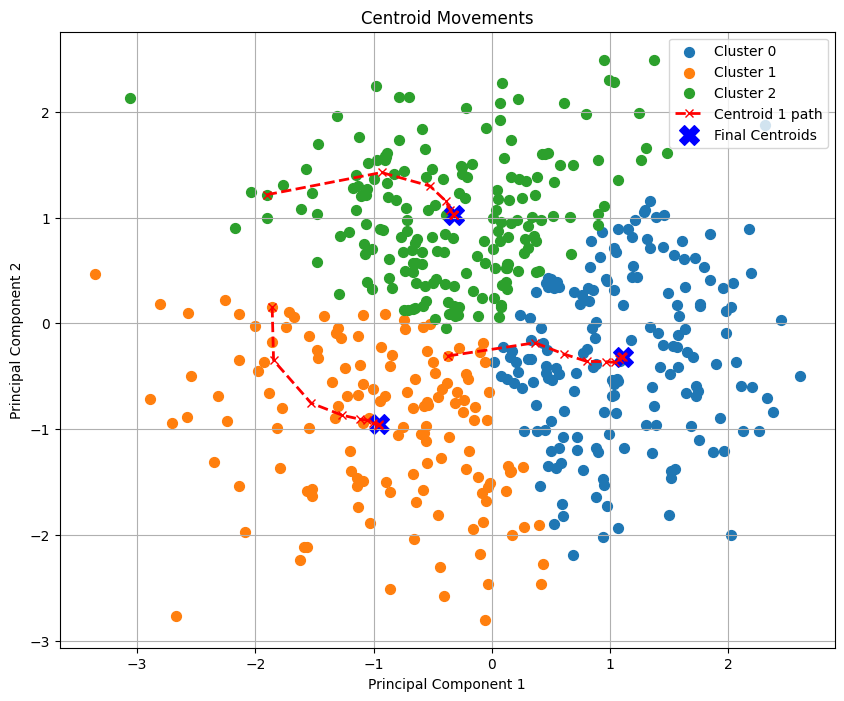

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Modified k-means to track centroid movements
def kmeans_em_with_tracking(data, k, max_iters=100, tol=1e-4):
    """K-Means algorithm with EM step, tracking centroids over iterations."""
    # Step 1: Initialize centroids
    centroids = initialize_centroids(data, k)
    centroids_history = [centroids.copy()]  # Store centroids at each iteration

    for i in range(max_iters):
        # Step 2: E-step: Assign clusters
        labels = assign_clusters(data, centroids)

        # Step 3: M-step: Update centroids
        new_centroids = update_centroids(data, labels, k)

        # Step 4: Check for convergence
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
        centroids_history.append(centroids.copy())  # Track centroid positions

    return labels, centroids, centroids_history

# Apply k-means with tracking
k = 3  # Number of clusters
labels, final_centroids, centroids_history = kmeans_em_with_tracking(reduced_data, k)

# Visualization of centroids moving across iterations
def plot_centroid_movement(data, labels, centroids_history, title='Centroid Movements'):
    plt.figure(figsize=(10, 8))

    # Plot the data points with cluster colors
    for cluster in np.unique(labels):
        plt.scatter(data[labels == cluster, 0], data[labels == cluster, 1], label=f'Cluster {cluster}', s=50)

    # Plot the centroid movements
    for i in range(len(centroids_history[0])):
        centroid_positions = np.array([centroids[i] for centroids in centroids_history])
        plt.plot(centroid_positions[:, 0], centroid_positions[:, 1], marker='x', linestyle='--', color='red', lw=2, label=f'Centroid {i+1} path' if i == 0 else "")

    # Mark the final centroids
    plt.scatter(final_centroids[:, 0], final_centroids[:, 1], s=200, color='blue', marker='X', label='Final Centroids')

    # Labels and legends
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize the centroid movements
plot_centroid_movement(reduced_data, labels, centroids_history)